# Classical regression models

* KNN
* Kernel SVM
* Random Forest

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from training.creating_dataset import load_and_preprocess_data
from training.constants import FEATURES, DATASET_FILES, ORDERED_CHARACTERISTICS_FULL


bestiaries = load_and_preprocess_data(
    [f"../../pathfinder_2e_remaster_data/{f}" for f in DATASET_FILES], FEATURES
)

columns = [col for col in bestiaries.columns if col not in ["book", "level"]]
scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[columns] = pd.DataFrame(
    scaler.fit_transform(bestiaries[columns]), index=bestiaries.index
)
min_max_df["book"] = bestiaries["book"]
min_max_df["level"] = bestiaries["level"]
bestiaries = min_max_df
bestiaries = bestiaries[ORDERED_CHARACTERISTICS_FULL + ["book", "level"]]
bestiaries.head()

,str,dex,con,int,wis,cha,ac,hp,perception,fortitude,...,area-damage_weakness,cold_weakness,cold-iron_weakness,evil_weakness,fire_weakness,good_weakness,slashing_weakness,splash-damage_weakness,book,level
0,0.588235,0.588235,0.357143,0.200000,0.470588,0.529412,0.509434,0.252087,0.156522,0.425532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,8
1,0.588235,0.411765,0.428571,0.600000,0.411765,0.411765,0.396226,0.123539,0.130435,0.297872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #163: Ruins of Gauntlight,5
2,0.529412,0.470588,0.214286,0.400000,0.470588,0.352941,0.320755,0.078464,0.069565,0.170213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #163: Ruins of Gauntlight,3
3,0.352941,0.529412,0.214286,0.333333,0.470588,0.352941,0.358491,0.048414,0.104348,0.170213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,3
4,0.588235,0.588235,0.500000,0.466667,0.529412,0.588235,0.490566,0.198664,0.156522,0.361702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,8


In [2]:
import os
from training.splitting_dataset import split_dataframe, get_date_books_mapping

os.chdir("../../training")
books_dates_map = get_date_books_mapping()

books_to_include = [
    book for _, row in books_dates_map["books"].iteritems() for book in row
]
bestiaries = bestiaries[bestiaries["book"].isin(books_to_include)]
X_train, X_test, y_train, y_test = split_dataframe(bestiaries)
os.chdir("../notebooks/models")

In [5]:
X_test

,str,dex,con,int,wis,cha,ac,hp,perception,fortitude,...,poison_resistance,slashing_resistance,area-damage_weakness,cold_weakness,cold-iron_weakness,evil_weakness,fire_weakness,good_weakness,slashing_weakness,splash-damage_weakness
651,0.588235,0.470588,0.428571,0.000000,0.411765,0.176471,0.452830,0.148581,0.104348,0.340426,...,0.000000,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
652,0.000000,0.705882,0.357143,0.666667,0.588235,0.705882,0.547170,0.290484,0.191304,0.382979,...,0.000000,0.00,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
656,0.411765,0.588235,0.285714,0.400000,0.411765,0.588235,0.396226,0.081803,0.095652,0.191489,...,0.000000,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
657,0.588235,0.647059,0.428571,0.533333,0.411765,0.529412,0.490566,0.207012,0.139130,0.340426,...,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
659,0.647059,0.470588,0.428571,0.466667,0.647059,0.588235,0.490566,0.273790,0.156522,0.297872,...,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,0.823529,0.647059,0.571429,0.666667,0.764706,0.647059,0.773585,0.632721,0.260870,0.595745,...,0.000000,0.00,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0
1477,0.647059,0.352941,0.571429,0.466667,0.470588,0.411765,0.490566,0.228715,0.139130,0.382979,...,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1478,0.823529,0.588235,0.571429,0.200000,0.588235,0.529412,0.754717,0.632721,0.278261,0.680851,...,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1479,0.000000,0.470588,0.285714,0.666667,0.411765,0.529412,0.509434,0.248748,0.165217,0.404255,...,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


## KNeighbors

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


clf = KNeighborsRegressor()

hyper_params = {
    "leaf_size": list(range(50, 100, 10)),
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan", "euclidean"],
    "n_neighbors": list(range(1, 51)),
}

model = GridSearchCV(
    estimator=clf,
    param_grid=hyper_params,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    return_train_score=True,
    n_jobs=-1,
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [50, 60, 70, 80, 90],
                         'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [4]:
model.best_params_

{'leaf_size': 50,
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


y_pred = model.predict(X_test)

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.2435195397196206
2.817641490858506


In [6]:
y_pred = model.predict(X_train)

print(mean_absolute_error(y_train, y_pred))
print(mean_squared_error(y_train, y_pred))

0.0
0.0


## SVM kernel=rbf

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


svm = SVR(kernel="rbf", max_iter=10000)
hyper_params = {"C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]}

model = GridSearchCV(
    estimator=svm,
    param_grid=hyper_params,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    return_train_score=True,
    n_jobs=-1,
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\jolka\OneDrive\Dokumenty\mgr\Predictive-ML-in-TTRPG-game-design\venv\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVR(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                               10000.0, 100000.0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [8]:
model.best_params_

{'C': 10.0}

In [9]:
svm = SVR(kernel="rbf", max_iter=10000)
hyper_params = {"C": np.linspace(1, 100, num=100)}

model = GridSearchCV(
    estimator=svm,
    param_grid=hyper_params,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    return_train_score=True,
    n_jobs=-1,
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVR(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [10]:
model.best_params_

{'C': 7.0}

In [11]:
svm = SVR(kernel="rbf", max_iter=10000)
hyper_params = {"C": np.linspace(1, 10, num=100)}

model = GridSearchCV(
    estimator=svm,
    param_grid=hyper_params,
    scoring="neg_absolute_error",
    cv=5,
    verbose=2,
    return_train_score=True,
    n_jobs=-1,
)
model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVR(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.09090909,  1.18181818,  1.27272727,  1.36363636,
        1.45454545,  1.54545455,  1.63636364,  1.72727273,  1.81818182,
        1.90909091,  2.        ,  2.09090909,  2.18181818,  2.27272727,
        2.36363636,  2.45454545,  2.54545455,  2.63636364,  2.72727273,
        2.81818182,  2.90909091,  3.        ,  3.09090909,  3.18181818,
        3.27272727,  3.36363...
        7.36363636,  7.45454545,  7.54545455,  7.63636364,  7.72727273,
        7.81818182,  7.90909091,  8.        ,  8.09090909,  8.18181818,
        8.27272727,  8.36363636,  8.45454545,  8.54545455,  8.63636364,
        8.72727273,  8.81818182,  8.90909091,  9.        ,  9.09090909,
        9.18181818,  9.27272727,  9.36363636,  9.45454545,  9.54545455,
        9.63636364,  9.72727273,  9.81818182,  9.90909091, 10.        ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [12]:
model.best_params_

{'C': 6.363636363636364}

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


y_pred = model.predict(X_test)

mean_absolute_error(y_test, y_pred)

0.5594337917196204

In [14]:
mean_squared_error(y_test, y_pred)

1.0202996727869298

In [15]:
y_pred = model.predict(X_train)

print(mean_absolute_error(y_train, y_pred))
print(mean_squared_error(y_train, y_pred))

0.19529077488239519
0.09230465868082151


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from training.constants import RANDOM_STATE


rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
hyper_params = {
    "max_features": [0.3],
    "n_estimators": [100, 200, 500],
    "criterion": ["squared_error", "absolute_error", "friedman_mse"],
}
model = GridSearchCV(
    estimator=rf,
    param_grid=hyper_params,
    scoring="neg_mean_absolute_error",
    cv=5,
    return_train_score=True,
    n_jobs=-1,
)
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse'],
                         'max_features': [0.3],
                         'n_estimators': [100, 200, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [11]:
model.best_params_

{'criterion': 'friedman_mse', 'max_features': 0.3, 'n_estimators': 500}

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


y_pred = model.predict(X_test)

mean_absolute_error(y_test, y_pred)

0.4382647058823529

In [13]:
mean_squared_error(y_test, y_pred)

0.5010076176470588

In [14]:
y_pred = model.predict(X_train)

print(mean_absolute_error(y_train, y_pred))
print(mean_squared_error(y_train, y_pred))

0.07843593519882176
0.01602683946980854


## All models

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from training.creating_dataset import load_and_preprocess_data
from training.constants import FEATURES, DATASET_FILES, ORDERED_CHARACTERISTICS_FULL


bestiaries = load_and_preprocess_data(
    [f"../../pathfinder_2e_remaster_data/{f}" for f in DATASET_FILES], FEATURES
)

In [2]:
columns = [col for col in bestiaries.columns if col not in ["book", "level"]]
scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[columns] = pd.DataFrame(
    scaler.fit_transform(bestiaries[columns]), index=bestiaries.index
)
min_max_df["book"] = bestiaries["book"]
min_max_df["level"] = bestiaries["level"]
bestiaries = min_max_df
bestiaries = bestiaries[ORDERED_CHARACTERISTICS_FULL + ["book", "level"]]
bestiaries.head()

,str,dex,con,int,wis,cha,ac,hp,perception,fortitude,...,area-damage_weakness,cold_weakness,cold-iron_weakness,evil_weakness,fire_weakness,good_weakness,slashing_weakness,splash-damage_weakness,book,level
0,0.588235,0.588235,0.357143,0.200000,0.470588,0.529412,0.509434,0.252087,0.156522,0.425532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,8
1,0.588235,0.411765,0.428571,0.600000,0.411765,0.411765,0.396226,0.123539,0.130435,0.297872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #163: Ruins of Gauntlight,5
2,0.529412,0.470588,0.214286,0.400000,0.470588,0.352941,0.320755,0.078464,0.069565,0.170213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #163: Ruins of Gauntlight,3
3,0.352941,0.529412,0.214286,0.333333,0.470588,0.352941,0.358491,0.048414,0.104348,0.170213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,3
4,0.588235,0.588235,0.500000,0.466667,0.529412,0.588235,0.490566,0.198664,0.156522,0.361702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pathfinder #164: Hands of the Devil,8


In [3]:
import os
from training.splitting_dataset import split_dataframe, get_date_books_mapping


os.chdir("../../training")
books_dates_map = get_date_books_mapping()
# os.chdir("../notebooks/models")
books_to_include = [
    book for _, row in books_dates_map["books"].iteritems() for book in row
]
bestiaries = bestiaries[bestiaries["book"].isin(books_to_include)]
# os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(bestiaries)
os.chdir("../notebooks/models")

In [4]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 1359 entries, 2929 to 2614
Series name: level
Non-Null Count  Dtype
--------------  -----
1359 non-null   int64
dtypes: int64(1)
memory usage: 21.2 KB


In [5]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 272 entries, 651 to 1480
Series name: level
Non-Null Count  Dtype
--------------  -----
272 non-null    int64
dtypes: int64(1)
memory usage: 4.2 KB


In [6]:
from training.train_and_evaluate_models import train_and_evaluate_models


results = train_and_evaluate_models(
    [
        "kernel_svm",
        "knn",
        "random_forest",
        "lightgbm",
    ],
    X_train,
    y_train,
    X_test,
    y_test,
    thresholds=[[0.05 * i for i in range(1, 20)], [0.05 * i for i in range(5, 16)]],
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\jolka\OneDrive\Dokumenty\mgr\Predictive-ML-in-TTRPG-game-design\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
[I 2024-05-23 21:05:59,136] A new study created in memory with name: no-name-c0988ad0-85e6-4e7d-98ad-bbb5e7fd257b
[I 2024-05-23 21:05:59,158] Trial 0 finished with value: 0.12067696835908756 and parameters: {'level_-1': 0.18197759279829007, 'level_0': 0.7066055163900721, 'level_1': 0.5537947302241821, 'level_2': 0.3341228422714621, 'level_3': 0.7940285364028575, 'level_4': 0.21202091074809992, 'level_5': 0.7475513132738725, 'level_6': 0.8036185415764381, 'level_7': 0.5963522903422339, 'level_8': 0.7103341875425329, 'level_9': 0.18673681336585118, 'level_10': 0.11758605761654167, 'level_11': 0.08036660344599267, 'level_12': 0.7740512107471818, 'level_13': 0.38873220545294895, 'level_14': 0.17357471012342088, 'level_15'

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[I 2024-05-23 21:11:11,262] A new study created in memory with name: no-name-3b2308f6-b4b8-4961-b857-e93651769c6e
[I 2024-05-23 21:11:11,283] Trial 0 finished with value: 0.0 and parameters: {'level_-1': 0.5523704992505138, 'level_0': 0.08816328944892884, 'level_1': 0.08143337698372823, 'level_2': 0.38503124139658423, 'level_3': 0.8417838999608562, 'level_4': 0.4950712867990258, 'level_5': 0.9262012311641967, 'level_6': 0.83068508474282, 'level_7': 0.6135346871839891, 'level_8': 0.716564834608283, 'level_9': 0.46870847261230425, 'level_10': 0.8557995108191666, 'level_11': 0.6439911573758573, 'level_12': 0.15336372516565444, 'level_13': 0.903842169179296, 'level_14': 0.928016767214745, 'level_15': 0.8125528860563362, 'level_16': 0.28347396441473866, 'level_17': 0.7010264673627743, 'level_18': 0.3374924231055545, 'level_19': 0.8371461525631785, 'level_20': 0.20365816872851744}. Best is trial 0 with value: 0.0.
[I 2024-05-23 21:11:11,330] Trial 1 finished with value: 0.0 and parameters: {

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.201122 + 0.122541
[200]	cv_agg's l2: 0.196748 + 0.125249
[300]	cv_agg's l2: 0.195123 + 0.124439
[400]	cv_agg's l2: 0.194673 + 0.124805
[500]	cv_agg's l2: 0.194698 + 0.125386
[600]	cv_agg's l2: 0.19441 + 0.12519
[700]	cv_agg's l2: 0.194327 + 0.125313
[800]	cv_agg's l2: 0.194305 + 0.125422


feature_fraction, val_score: 0.194282:  14%|#4        | 1/7 [37:03<3:42:22, 2223.81s/it]

[900]	cv_agg's l2: 0.1944 + 0.125729
Early stopping, best iteration is:
[802]	cv_agg's l2: 0.194282 + 0.125404
[100]	cv_agg's l2: 0.216487 + 0.149814
[200]	cv_agg's l2: 0.208842 + 0.144058
[300]	cv_agg's l2: 0.206344 + 0.142192
[400]	cv_agg's l2: 0.206053 + 0.142275
[500]	cv_agg's l2: 0.206149 + 0.142487
[600]	cv_agg's l2: 0.206051 + 0.142614
[700]	cv_agg's l2: 0.206179 + 0.142957
[800]	cv_agg's l2: 0.206123 + 0.142951


feature_fraction, val_score: 0.194282:  29%|##8       | 2/7 [37:41<1:18:10, 938.01s/it]

[900]	cv_agg's l2: 0.206108 + 0.143045
Early stopping, best iteration is:
[802]	cv_agg's l2: 0.194282 + 0.125404
[100]	cv_agg's l2: 0.147195 + 0.0561504
[200]	cv_agg's l2: 0.142754 + 0.0543125
[300]	cv_agg's l2: 0.141729 + 0.0533362
[400]	cv_agg's l2: 0.141523 + 0.0531328


feature_fraction, val_score: 0.141337:  43%|####2     | 3/7 [38:04<34:40, 520.06s/it]

Early stopping, best iteration is:
[362]	cv_agg's l2: 0.141337 + 0.0529059
[100]	cv_agg's l2: 0.174113 + 0.100988
[200]	cv_agg's l2: 0.169877 + 0.10052
[300]	cv_agg's l2: 0.168223 + 0.0997218
[400]	cv_agg's l2: 0.168186 + 0.0999929


feature_fraction, val_score: 0.141337:  57%|#####7    | 4/7 [38:19<16:02, 320.72s/it]

Early stopping, best iteration is:
[362]	cv_agg's l2: 0.141337 + 0.0529059
[100]	cv_agg's l2: 0.196107 + 0.122808
[200]	cv_agg's l2: 0.189633 + 0.12036
[300]	cv_agg's l2: 0.188479 + 0.119754
[400]	cv_agg's l2: 0.188307 + 0.12017


feature_fraction, val_score: 0.141337:  71%|#######1  | 5/7 [38:30<06:58, 209.11s/it]

Early stopping, best iteration is:
[362]	cv_agg's l2: 0.141337 + 0.0529059
[100]	cv_agg's l2: 0.18946 + 0.113298
[200]	cv_agg's l2: 0.18451 + 0.112341
[300]	cv_agg's l2: 0.182954 + 0.110954
[400]	cv_agg's l2: 0.182787 + 0.111315


feature_fraction, val_score: 0.141337:  86%|########5 | 6/7 [38:40<02:21, 141.44s/it]

Early stopping, best iteration is:
[362]	cv_agg's l2: 0.141337 + 0.0529059
[100]	cv_agg's l2: 0.159492 + 0.0784567
[200]	cv_agg's l2: 0.154322 + 0.0742951
[300]	cv_agg's l2: 0.152527 + 0.0735765
[400]	cv_agg's l2: 0.152356 + 0.0731972


feature_fraction, val_score: 0.141337: 100%|##########| 7/7 [38:51<00:00, 333.12s/it]


Early stopping, best iteration is:
[362]	cv_agg's l2: 0.141337 + 0.0529059


num_leaves, val_score: 0.141337:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.138950:   5%|5         | 1/20 [00:17<05:29, 17.35s/it]

Early stopping, best iteration is:
[534]	cv_agg's l2: 0.13895 + 0.0547024
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.138950:  10%|#         | 2/20 [00:44<06:55, 23.07s/it]

Early stopping, best iteration is:
[534]	cv_agg's l2: 0.13895 + 0.0547024
[100]	cv_agg's l2: 0.143557 + 0.056376
[200]	cv_agg's l2: 0.13909 + 0.0544532
[300]	cv_agg's l2: 0.13813 + 0.0534
[400]	cv_agg's l2: 0.137601 + 0.0534997
[500]	cv_agg's l2: 0.137449 + 0.053239
[600]	cv_agg's l2: 0.13758 + 0.0534447


num_leaves, val_score: 0.137412:  15%|#5        | 3/20 [01:02<05:52, 20.71s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.358048 + 0.128064
[200]	cv_agg's l2: 0.297424 + 0.0893538
[300]	cv_agg's l2: 0.281775 + 0.0829969
[400]	cv_agg's l2: 0.272305 + 0.0789563
[500]	cv_agg's l2: 0.266029 + 0.0781396


num_leaves, val_score: 0.137412:  20%|##        | 4/20 [01:05<03:40, 13.75s/it]

[600]	cv_agg's l2: 0.261339 + 0.0765838
Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


[I 2024-05-23 21:55:36,503] Trial 10 finished with value: 0.26400368323727846 and parameters: {'num_leaves': 2}. Best is trial 9 with value: 0.13741164112905843.
num_leaves, val_score: 0.137412:  20%|##        | 4/20 [01:05<03:40, 13.75s/it]

[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  25%|##5       | 5/20 [01:23<03:51, 15.45s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  30%|###       | 6/20 [01:43<03:58, 17.00s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  35%|###5      | 7/20 [02:02<03:46, 17.42s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  40%|####      | 8/20 [02:21<03:34, 17.89s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  45%|####5     | 9/20 [02:39<03:18, 18.01s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.232996 + 0.0741511
[200]	cv_agg's l2: 0.197999 + 0.0647443
[300]	cv_agg's l2: 0.182881 + 0.0599049
[400]	cv_agg's l2: 0.175565 + 0.0591868
[500]	cv_agg's l2: 0.168258 + 0.0550359


num_leaves, val_score: 0.137412:  45%|####5     | 9/20 [02:45<03:18, 18.01s/it]

[600]	cv_agg's l2: 0.162961 + 0.0521866
Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


num_leaves, val_score: 0.137412:  50%|#####     | 10/20 [02:45<02:23, 14.33s/it]

[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  55%|#####5    | 11/20 [03:08<02:32, 16.89s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  60%|######    | 12/20 [03:26<02:17, 17.24s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  65%|######5   | 13/20 [03:47<02:08, 18.39s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  70%|#######   | 14/20 [04:09<01:58, 19.71s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  75%|#######5  | 15/20 [04:31<01:40, 20.18s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  80%|########  | 16/20 [04:49<01:18, 19.51s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412:  85%|########5 | 17/20 [05:13<01:02, 20.84s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.144276 + 0.0568306
[200]	cv_agg's l2: 0.140326 + 0.0541156
[300]	cv_agg's l2: 0.139342 + 0.0530602
[400]	cv_agg's l2: 0.139082 + 0.0527501
[500]	cv_agg's l2: 0.138924 + 0.0525051
[600]	cv_agg's l2: 0.138966 + 0.0525437


num_leaves, val_score: 0.137412:  90%|######### | 18/20 [05:29<00:38, 19.48s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.148611 + 0.0596936
[200]	cv_agg's l2: 0.142621 + 0.0559732
[300]	cv_agg's l2: 0.141436 + 0.0563357
[400]	cv_agg's l2: 0.141504 + 0.0564671
[500]	cv_agg's l2: 0.141267 + 0.0560394
[600]	cv_agg's l2: 0.141206 + 0.0560531


num_leaves, val_score: 0.137412:  95%|#########5| 19/20 [05:47<00:19, 19.00s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145994 + 0.0586038
[200]	cv_agg's l2: 0.140851 + 0.0568272
[300]	cv_agg's l2: 0.13956 + 0.0553199
[400]	cv_agg's l2: 0.139333 + 0.0550998
[500]	cv_agg's l2: 0.138966 + 0.0546617
[600]	cv_agg's l2: 0.139043 + 0.0547964


num_leaves, val_score: 0.137412: 100%|##########| 20/20 [06:05<00:00, 18.25s/it]


Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


bagging, val_score: 0.137412:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160826 + 0.0687637
[200]	cv_agg's l2: 0.153789 + 0.0654056
[300]	cv_agg's l2: 0.15122 + 0.0643438
[400]	cv_agg's l2: 0.150801 + 0.0633528
[500]	cv_agg's l2: 0.150174 + 0.0618019
[600]	cv_agg's l2: 0.150212 + 0.0618656


bagging, val_score: 0.137412:  10%|#         | 1/10 [00:17<02:41, 17.94s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.168874 + 0.0616167
[200]	cv_agg's l2: 0.155241 + 0.047293
[300]	cv_agg's l2: 0.152018 + 0.0445207
[400]	cv_agg's l2: 0.150978 + 0.0448509
[500]	cv_agg's l2: 0.150115 + 0.042961
[600]	cv_agg's l2: 0.148902 + 0.041766


bagging, val_score: 0.137412:  20%|##        | 2/10 [00:29<01:53, 14.17s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145796 + 0.0535046
[200]	cv_agg's l2: 0.141392 + 0.0533871
[300]	cv_agg's l2: 0.140258 + 0.052558
[400]	cv_agg's l2: 0.139783 + 0.0517578
[500]	cv_agg's l2: 0.139954 + 0.0519912
[600]	cv_agg's l2: 0.140077 + 0.0519681


bagging, val_score: 0.137412:  30%|###       | 3/10 [00:48<01:55, 16.56s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.158245 + 0.0654772
[200]	cv_agg's l2: 0.153135 + 0.0638492
[300]	cv_agg's l2: 0.15247 + 0.0634404
[400]	cv_agg's l2: 0.151641 + 0.0625437
[500]	cv_agg's l2: 0.151693 + 0.0623069
[600]	cv_agg's l2: 0.151483 + 0.0620316


bagging, val_score: 0.137412:  40%|####      | 4/10 [01:08<01:47, 17.96s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.172614 + 0.0439144
[200]	cv_agg's l2: 0.164036 + 0.045092
[300]	cv_agg's l2: 0.160986 + 0.0388615
[400]	cv_agg's l2: 0.159293 + 0.0376488
[500]	cv_agg's l2: 0.161126 + 0.0375901
[600]	cv_agg's l2: 0.159479 + 0.0384166


bagging, val_score: 0.137412:  50%|#####     | 5/10 [01:20<01:18, 15.65s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.154968 + 0.0507038
[200]	cv_agg's l2: 0.148159 + 0.0477804
[300]	cv_agg's l2: 0.147729 + 0.0480884
[400]	cv_agg's l2: 0.148054 + 0.0472987
[500]	cv_agg's l2: 0.147207 + 0.0466117
[600]	cv_agg's l2: 0.147507 + 0.0463051


bagging, val_score: 0.137412:  60%|######    | 6/10 [01:31<00:56, 14.12s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145939 + 0.0529035
[200]	cv_agg's l2: 0.138929 + 0.0483528
[300]	cv_agg's l2: 0.138553 + 0.0470828
[400]	cv_agg's l2: 0.137989 + 0.0458118
[500]	cv_agg's l2: 0.138358 + 0.0459589
[600]	cv_agg's l2: 0.138511 + 0.0457196


bagging, val_score: 0.137412:  70%|#######   | 7/10 [01:46<00:42, 14.24s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.150174 + 0.0571054
[200]	cv_agg's l2: 0.142251 + 0.0529106
[300]	cv_agg's l2: 0.141411 + 0.0533158
[400]	cv_agg's l2: 0.140376 + 0.0524408
[500]	cv_agg's l2: 0.140282 + 0.052524
[600]	cv_agg's l2: 0.140356 + 0.0524027


bagging, val_score: 0.137412:  80%|########  | 8/10 [02:01<00:29, 14.53s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.14714 + 0.0573395
[200]	cv_agg's l2: 0.142613 + 0.0559176
[300]	cv_agg's l2: 0.141763 + 0.0558146
[400]	cv_agg's l2: 0.141262 + 0.0554422
[500]	cv_agg's l2: 0.14104 + 0.0553636
[600]	cv_agg's l2: 0.141132 + 0.0553025


bagging, val_score: 0.137412:  90%|######### | 9/10 [02:18<00:15, 15.35s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.148864 + 0.0517805
[200]	cv_agg's l2: 0.143565 + 0.0504114
[300]	cv_agg's l2: 0.141764 + 0.0474712
[400]	cv_agg's l2: 0.141534 + 0.047766
[500]	cv_agg's l2: 0.141316 + 0.0468186
[600]	cv_agg's l2: 0.141548 + 0.0468988


bagging, val_score: 0.137412: 100%|##########| 10/10 [02:33<00:00, 15.31s/it]


Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


feature_fraction_stage2, val_score: 0.137412:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.147926 + 0.0569857
[200]	cv_agg's l2: 0.144419 + 0.0563307
[300]	cv_agg's l2: 0.144004 + 0.056227
[400]	cv_agg's l2: 0.143784 + 0.0561682
[500]	cv_agg's l2: 0.143633 + 0.0559762
[600]	cv_agg's l2: 0.143611 + 0.0561086


feature_fraction_stage2, val_score: 0.137412:  33%|###3      | 1/3 [00:19<00:38, 19.03s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.160943 + 0.0715394
[200]	cv_agg's l2: 0.156789 + 0.0723861
[300]	cv_agg's l2: 0.15616 + 0.0721371
[400]	cv_agg's l2: 0.155891 + 0.0721013
[500]	cv_agg's l2: 0.155888 + 0.0720095
[600]	cv_agg's l2: 0.155823 + 0.0720843


feature_fraction_stage2, val_score: 0.137412:  67%|######6   | 2/3 [00:37<00:18, 18.56s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.162533 + 0.0753141
[200]	cv_agg's l2: 0.15766 + 0.0706383
[300]	cv_agg's l2: 0.156744 + 0.0703254
[400]	cv_agg's l2: 0.15656 + 0.0702183
[500]	cv_agg's l2: 0.156607 + 0.0701037
[600]	cv_agg's l2: 0.156612 + 0.0701226


feature_fraction_stage2, val_score: 0.137412: 100%|##########| 3/3 [00:54<00:00, 18.03s/it]


Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


regularization_factors, val_score: 0.137412:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.148363 + 0.0593432
[200]	cv_agg's l2: 0.143367 + 0.0560032
[300]	cv_agg's l2: 0.142427 + 0.055853
[400]	cv_agg's l2: 0.141982 + 0.0554345
[500]	cv_agg's l2: 0.141854 + 0.0551738


regularization_factors, val_score: 0.137412:   0%|          | 0/20 [00:14<?, ?it/s]

[600]	cv_agg's l2: 0.141671 + 0.0550686
Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578


regularization_factors, val_score: 0.137412:   5%|5         | 1/20 [00:14<04:31, 14.31s/it]

[100]	cv_agg's l2: 0.156257 + 0.0575266
[200]	cv_agg's l2: 0.145477 + 0.0520879
[300]	cv_agg's l2: 0.143722 + 0.0516629
[400]	cv_agg's l2: 0.143122 + 0.0515904
[500]	cv_agg's l2: 0.143064 + 0.0515618
[600]	cv_agg's l2: 0.143257 + 0.0515498


regularization_factors, val_score: 0.137412:  10%|#         | 2/20 [00:29<04:24, 14.72s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.161344 + 0.0618109
[200]	cv_agg's l2: 0.152613 + 0.0557883
[300]	cv_agg's l2: 0.152171 + 0.0553775
[400]	cv_agg's l2: 0.152067 + 0.055184
[500]	cv_agg's l2: 0.152067 + 0.055184


regularization_factors, val_score: 0.137412:  15%|#5        | 3/20 [00:34<02:52, 10.16s/it]

[600]	cv_agg's l2: 0.152067 + 0.055184
Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.145836 + 0.0583191
[200]	cv_agg's l2: 0.140742 + 0.0567107
[300]	cv_agg's l2: 0.139618 + 0.0551955
[400]	cv_agg's l2: 0.139261 + 0.0549494
[500]	cv_agg's l2: 0.139405 + 0.0549924
[600]	cv_agg's l2: 0.139293 + 0.0549544


regularization_factors, val_score: 0.137412:  20%|##        | 4/20 [00:53<03:40, 13.81s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.143324 + 0.0547338
[200]	cv_agg's l2: 0.139052 + 0.0533957
[300]	cv_agg's l2: 0.138132 + 0.0525511
[400]	cv_agg's l2: 0.137602 + 0.052169
[500]	cv_agg's l2: 0.137586 + 0.0519641
[600]	cv_agg's l2: 0.137646 + 0.0519214


regularization_factors, val_score: 0.137412:  25%|##5       | 5/20 [01:03<03:07, 12.49s/it]

Early stopping, best iteration is:
[535]	cv_agg's l2: 0.137412 + 0.0532578
[100]	cv_agg's l2: 0.144485 + 0.0566443
[200]	cv_agg's l2: 0.138764 + 0.0534202
[300]	cv_agg's l2: 0.137733 + 0.0536093
[400]	cv_agg's l2: 0.137215 + 0.0531981
[500]	cv_agg's l2: 0.13703 + 0.0529914


regularization_factors, val_score: 0.137000:  30%|###       | 6/20 [01:10<02:27, 10.56s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.145599 + 0.0543835
[200]	cv_agg's l2: 0.141389 + 0.0530006
[300]	cv_agg's l2: 0.140117 + 0.0526101
[400]	cv_agg's l2: 0.13982 + 0.0523511
[500]	cv_agg's l2: 0.139707 + 0.0523851


regularization_factors, val_score: 0.137000:  35%|###5      | 7/20 [01:16<01:58,  9.15s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.144318 + 0.0543011
[200]	cv_agg's l2: 0.139644 + 0.0529716
[300]	cv_agg's l2: 0.138631 + 0.0522276
[400]	cv_agg's l2: 0.138387 + 0.0521681
[500]	cv_agg's l2: 0.138029 + 0.0518278


regularization_factors, val_score: 0.137000:  40%|####      | 8/20 [01:24<01:45,  8.79s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.146074 + 0.0591231
[200]	cv_agg's l2: 0.141457 + 0.0575774
[300]	cv_agg's l2: 0.140362 + 0.0569406
[400]	cv_agg's l2: 0.139896 + 0.0567388
[500]	cv_agg's l2: 0.139885 + 0.0563719


regularization_factors, val_score: 0.137000:  45%|####5     | 9/20 [01:30<01:26,  7.89s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.146471 + 0.0588443
[200]	cv_agg's l2: 0.141498 + 0.0573039
[300]	cv_agg's l2: 0.140851 + 0.0569845
[400]	cv_agg's l2: 0.140793 + 0.0568834
[500]	cv_agg's l2: 0.14075 + 0.0568307


regularization_factors, val_score: 0.137000:  50%|#####     | 10/20 [01:37<01:16,  7.63s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.14576 + 0.0564943
[200]	cv_agg's l2: 0.141617 + 0.0553906
[300]	cv_agg's l2: 0.140652 + 0.0547476
[400]	cv_agg's l2: 0.140402 + 0.0545942
[500]	cv_agg's l2: 0.140468 + 0.0548468


regularization_factors, val_score: 0.137000:  55%|#####5    | 11/20 [01:44<01:06,  7.39s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.14855 + 0.0612714
[200]	cv_agg's l2: 0.143686 + 0.0583912
[300]	cv_agg's l2: 0.142962 + 0.0576187
[400]	cv_agg's l2: 0.142665 + 0.0574856
[500]	cv_agg's l2: 0.142614 + 0.057356


regularization_factors, val_score: 0.137000:  60%|######    | 12/20 [01:50<00:56,  7.10s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.144851 + 0.0561746
[200]	cv_agg's l2: 0.141379 + 0.0555018
[300]	cv_agg's l2: 0.140579 + 0.0551092
[400]	cv_agg's l2: 0.140337 + 0.0549065
[500]	cv_agg's l2: 0.140199 + 0.0547588


regularization_factors, val_score: 0.137000:  65%|######5   | 13/20 [01:57<00:47,  6.83s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.147785 + 0.0582061
[200]	cv_agg's l2: 0.142489 + 0.0555485
[300]	cv_agg's l2: 0.141655 + 0.0553962
[400]	cv_agg's l2: 0.1414 + 0.0553306
[500]	cv_agg's l2: 0.141387 + 0.0552892


regularization_factors, val_score: 0.137000:  70%|#######   | 14/20 [02:05<00:43,  7.30s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.144776 + 0.0558507
[200]	cv_agg's l2: 0.141826 + 0.054077
[300]	cv_agg's l2: 0.140629 + 0.0538288
[400]	cv_agg's l2: 0.140183 + 0.0533202
[500]	cv_agg's l2: 0.140261 + 0.0538726


regularization_factors, val_score: 0.137000:  75%|#######5  | 15/20 [02:12<00:36,  7.23s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.143446 + 0.0538394
[200]	cv_agg's l2: 0.139216 + 0.051907
[300]	cv_agg's l2: 0.138212 + 0.050667
[400]	cv_agg's l2: 0.137901 + 0.0501442
[500]	cv_agg's l2: 0.13765 + 0.0498719


regularization_factors, val_score: 0.137000:  80%|########  | 16/20 [02:20<00:29,  7.34s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.148021 + 0.0623184
[200]	cv_agg's l2: 0.143645 + 0.0612523
[300]	cv_agg's l2: 0.142492 + 0.059881
[400]	cv_agg's l2: 0.141979 + 0.0593017
[500]	cv_agg's l2: 0.141792 + 0.0589374


regularization_factors, val_score: 0.137000:  85%|########5 | 17/20 [02:28<00:22,  7.48s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.146701 + 0.0540581
[200]	cv_agg's l2: 0.141051 + 0.0513437
[300]	cv_agg's l2: 0.140028 + 0.0515904
[400]	cv_agg's l2: 0.139556 + 0.0511912
[500]	cv_agg's l2: 0.139406 + 0.0510181


regularization_factors, val_score: 0.137000:  90%|######### | 18/20 [02:34<00:14,  7.30s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.150987 + 0.0587791
[200]	cv_agg's l2: 0.14455 + 0.0567611
[300]	cv_agg's l2: 0.143087 + 0.0566684
[400]	cv_agg's l2: 0.142899 + 0.0564872


regularization_factors, val_score: 0.137000:  95%|#########5| 19/20 [02:39<00:06,  6.49s/it]

[500]	cv_agg's l2: 0.142932 + 0.0564498
Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.143794 + 0.0552373
[200]	cv_agg's l2: 0.139215 + 0.0526745
[300]	cv_agg's l2: 0.138338 + 0.0519732
[400]	cv_agg's l2: 0.138074 + 0.0517805
[500]	cv_agg's l2: 0.138019 + 0.0519407


regularization_factors, val_score: 0.137000: 100%|##########| 20/20 [02:49<00:00,  8.46s/it]


Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266


min_data_in_leaf, val_score: 0.137000:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.190882 + 0.062182
[200]	cv_agg's l2: 0.177438 + 0.0545103
[300]	cv_agg's l2: 0.174323 + 0.0540682
[400]	cv_agg's l2: 0.171517 + 0.0524417
[500]	cv_agg's l2: 0.170147 + 0.0512569


min_data_in_leaf, val_score: 0.137000:  20%|##        | 1/5 [00:03<00:13,  3.47s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.154462 + 0.0479177
[200]	cv_agg's l2: 0.152607 + 0.047454
[300]	cv_agg's l2: 0.15238 + 0.0473184
[400]	cv_agg's l2: 0.152275 + 0.0473233
[500]	cv_agg's l2: 0.152353 + 0.0474088


min_data_in_leaf, val_score: 0.137000:  40%|####      | 2/5 [00:10<00:17,  5.83s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.153671 + 0.0578719
[200]	cv_agg's l2: 0.150266 + 0.0579166
[300]	cv_agg's l2: 0.149812 + 0.057851
[400]	cv_agg's l2: 0.149942 + 0.058038
[500]	cv_agg's l2: 0.150132 + 0.058046


min_data_in_leaf, val_score: 0.137000:  60%|######    | 3/5 [00:17<00:12,  6.07s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.145349 + 0.0492711
[200]	cv_agg's l2: 0.139741 + 0.0448102
[300]	cv_agg's l2: 0.138656 + 0.0444821
[400]	cv_agg's l2: 0.13848 + 0.0445007
[500]	cv_agg's l2: 0.138537 + 0.0441144


min_data_in_leaf, val_score: 0.137000:  80%|########  | 4/5 [00:23<00:06,  6.22s/it]

Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266
[100]	cv_agg's l2: 0.405937 + 0.110507
[200]	cv_agg's l2: 0.383332 + 0.101117
[300]	cv_agg's l2: 0.374076 + 0.0967541
[400]	cv_agg's l2: 0.368058 + 0.0932721
[500]	cv_agg's l2: 0.364485 + 0.091939
Early stopping, best iteration is:
[458]	cv_agg's l2: 0.137 + 0.0530266


min_data_in_leaf, val_score: 0.137000: 100%|##########| 5/5 [00:26<00:00,  5.29s/it]
[I 2024-05-23 22:07:30,512] A new study created in memory with name: no-name-d6e36b62-6e3a-4fd6-9b38-09de31513160
[I 2024-05-23 22:07:30,523] Trial 0 finished with value: 0.0 and parameters: {'level_-1': 0.553746050159678, 'level_0': 0.14525443122824575, 'level_1': 0.09230720347259086, 'level_2': 0.6931265656717069, 'level_3': 0.2720729319372478, 'level_4': 0.8849518163747098, 'level_5': 0.8305525329132705, 'level_6': 0.9125232975586376, 'level_7': 0.7719042751225076, 'level_8': 0.34287078191011644, 'level_9': 0.43171748685735256, 'level_10': 0.8365325700755712, 'level_11': 0.45325698834548567, 'level_12': 0.691437482375124, 'level_13': 0.2233922531119945, 'level_14': 0.9302012932124383, 'level_15': 0.25459159556359695, 'level_16': 0.46809634398430466, 'level_17': 0.15473442798810166, 'level_18': 0.4861636263167594, 'level_19': 0.44916754608684883, 'level_20': 0.8829975452506978}. Best is trial 0 with 

### Train/Test results

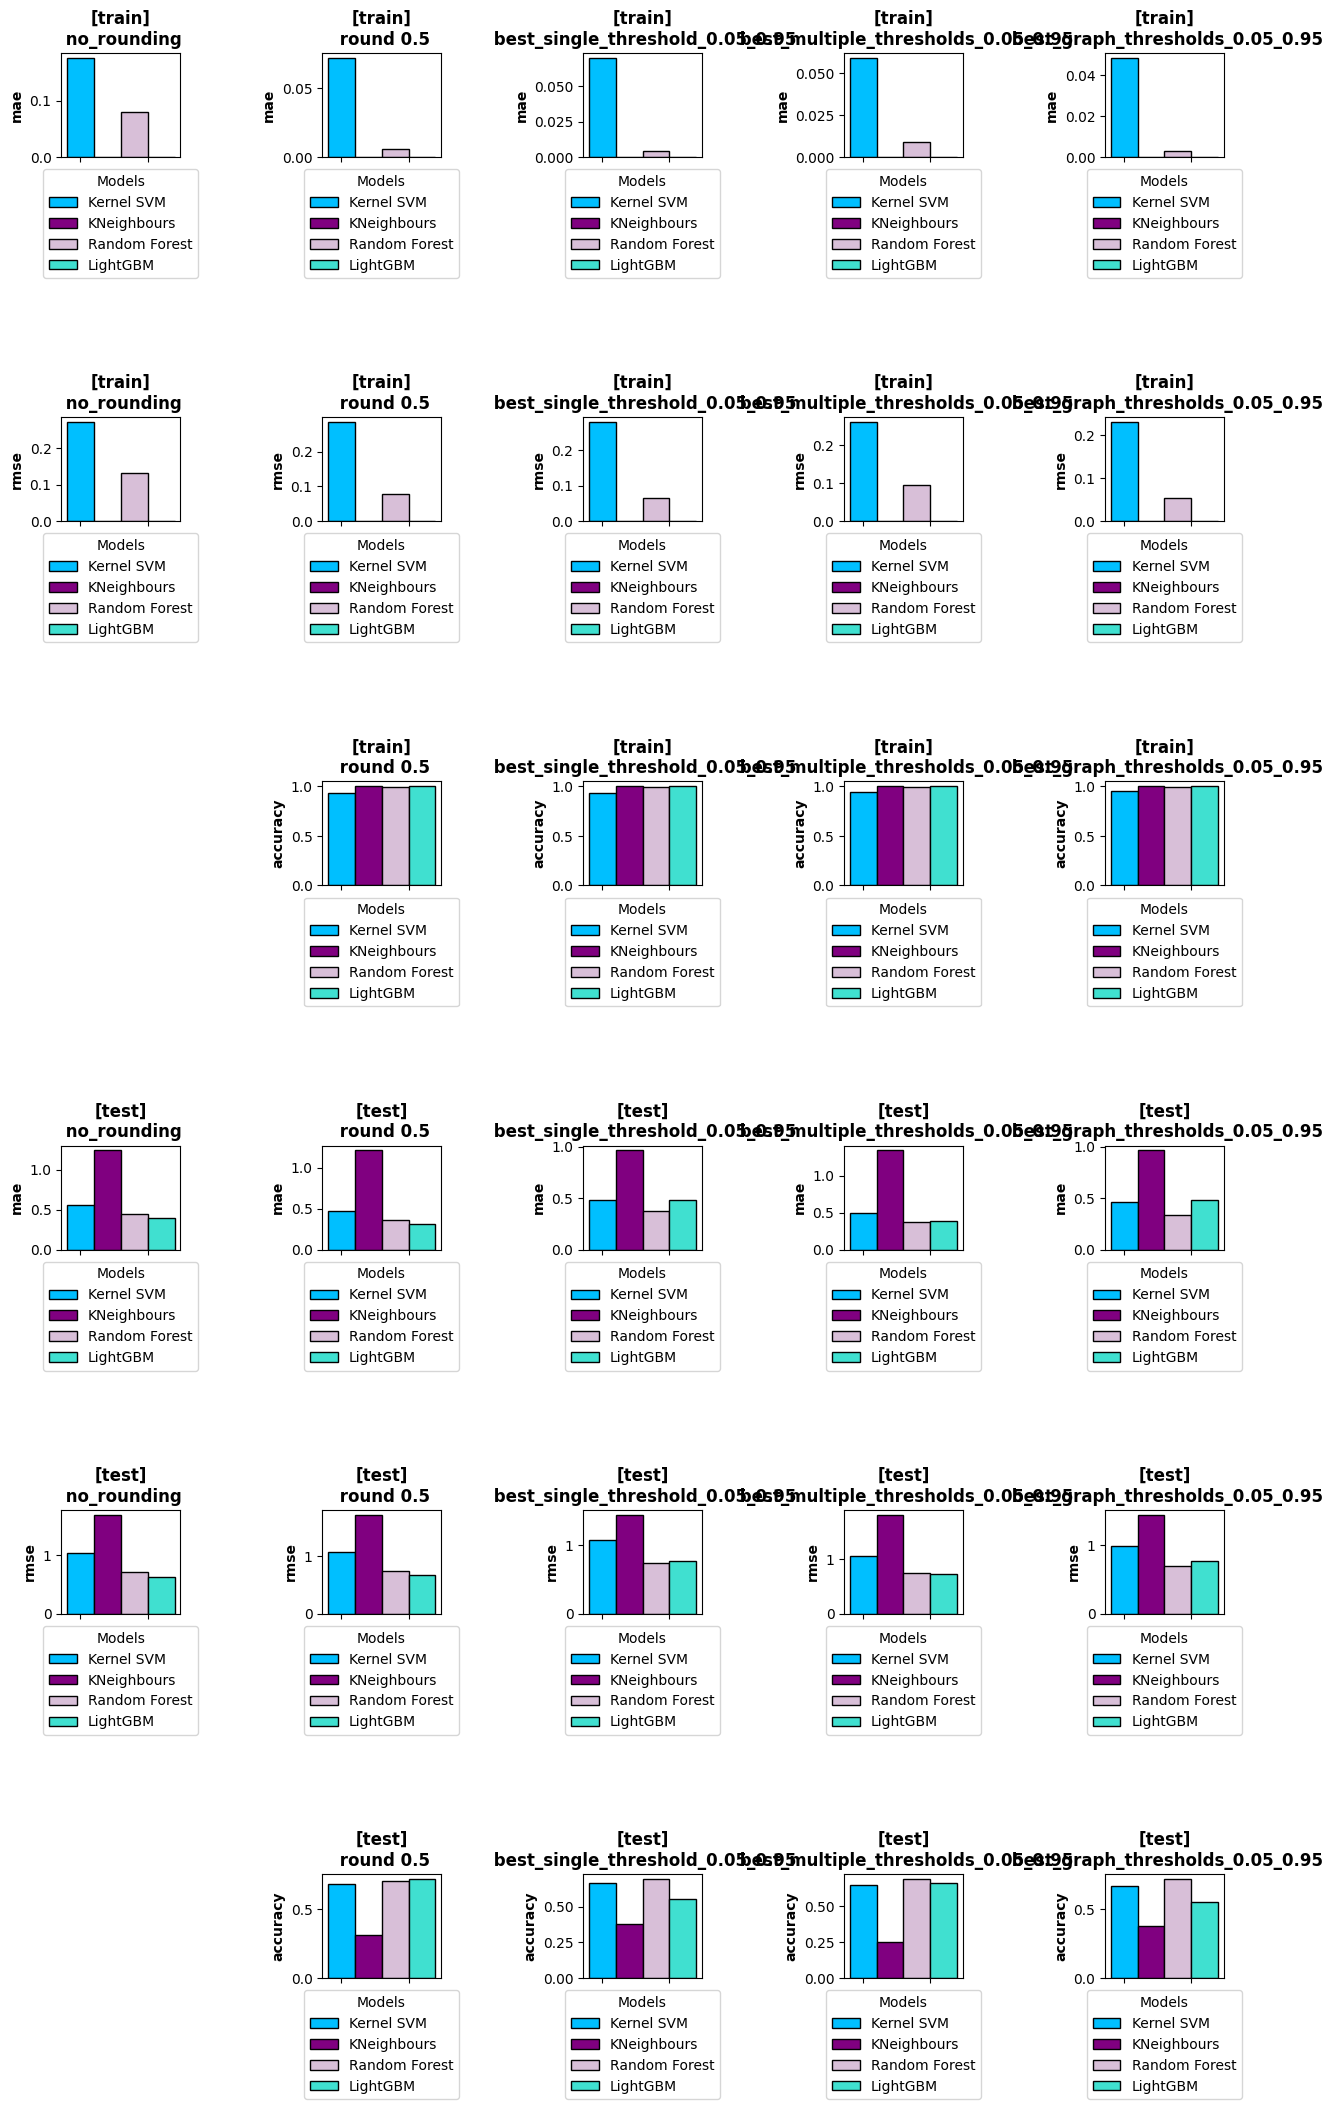

In [8]:
from training.results import plot_results


plot_results(
    results,
    measure_types=["mae", "rmse", "accuracy"],
    figsize=(15, 25),
    sets=[
        "train",
        "test",
    ],
    rounding_types=[
        "no_rounding",
        "round 0.5",
        "best_single_threshold_0.05_0.95",
        "best_multiple_thresholds_0.05_0.95",
        "best_graph_thresholds_0.05_0.95",
        # "best_single_threshold_0.25_0.75",
        # "best_multiple_thresholds_0.25_0.75",
        # "best_graph_thresholds_0.25_0.75",
    ],
    hspace=2.5,
    wspace=1.2,
)

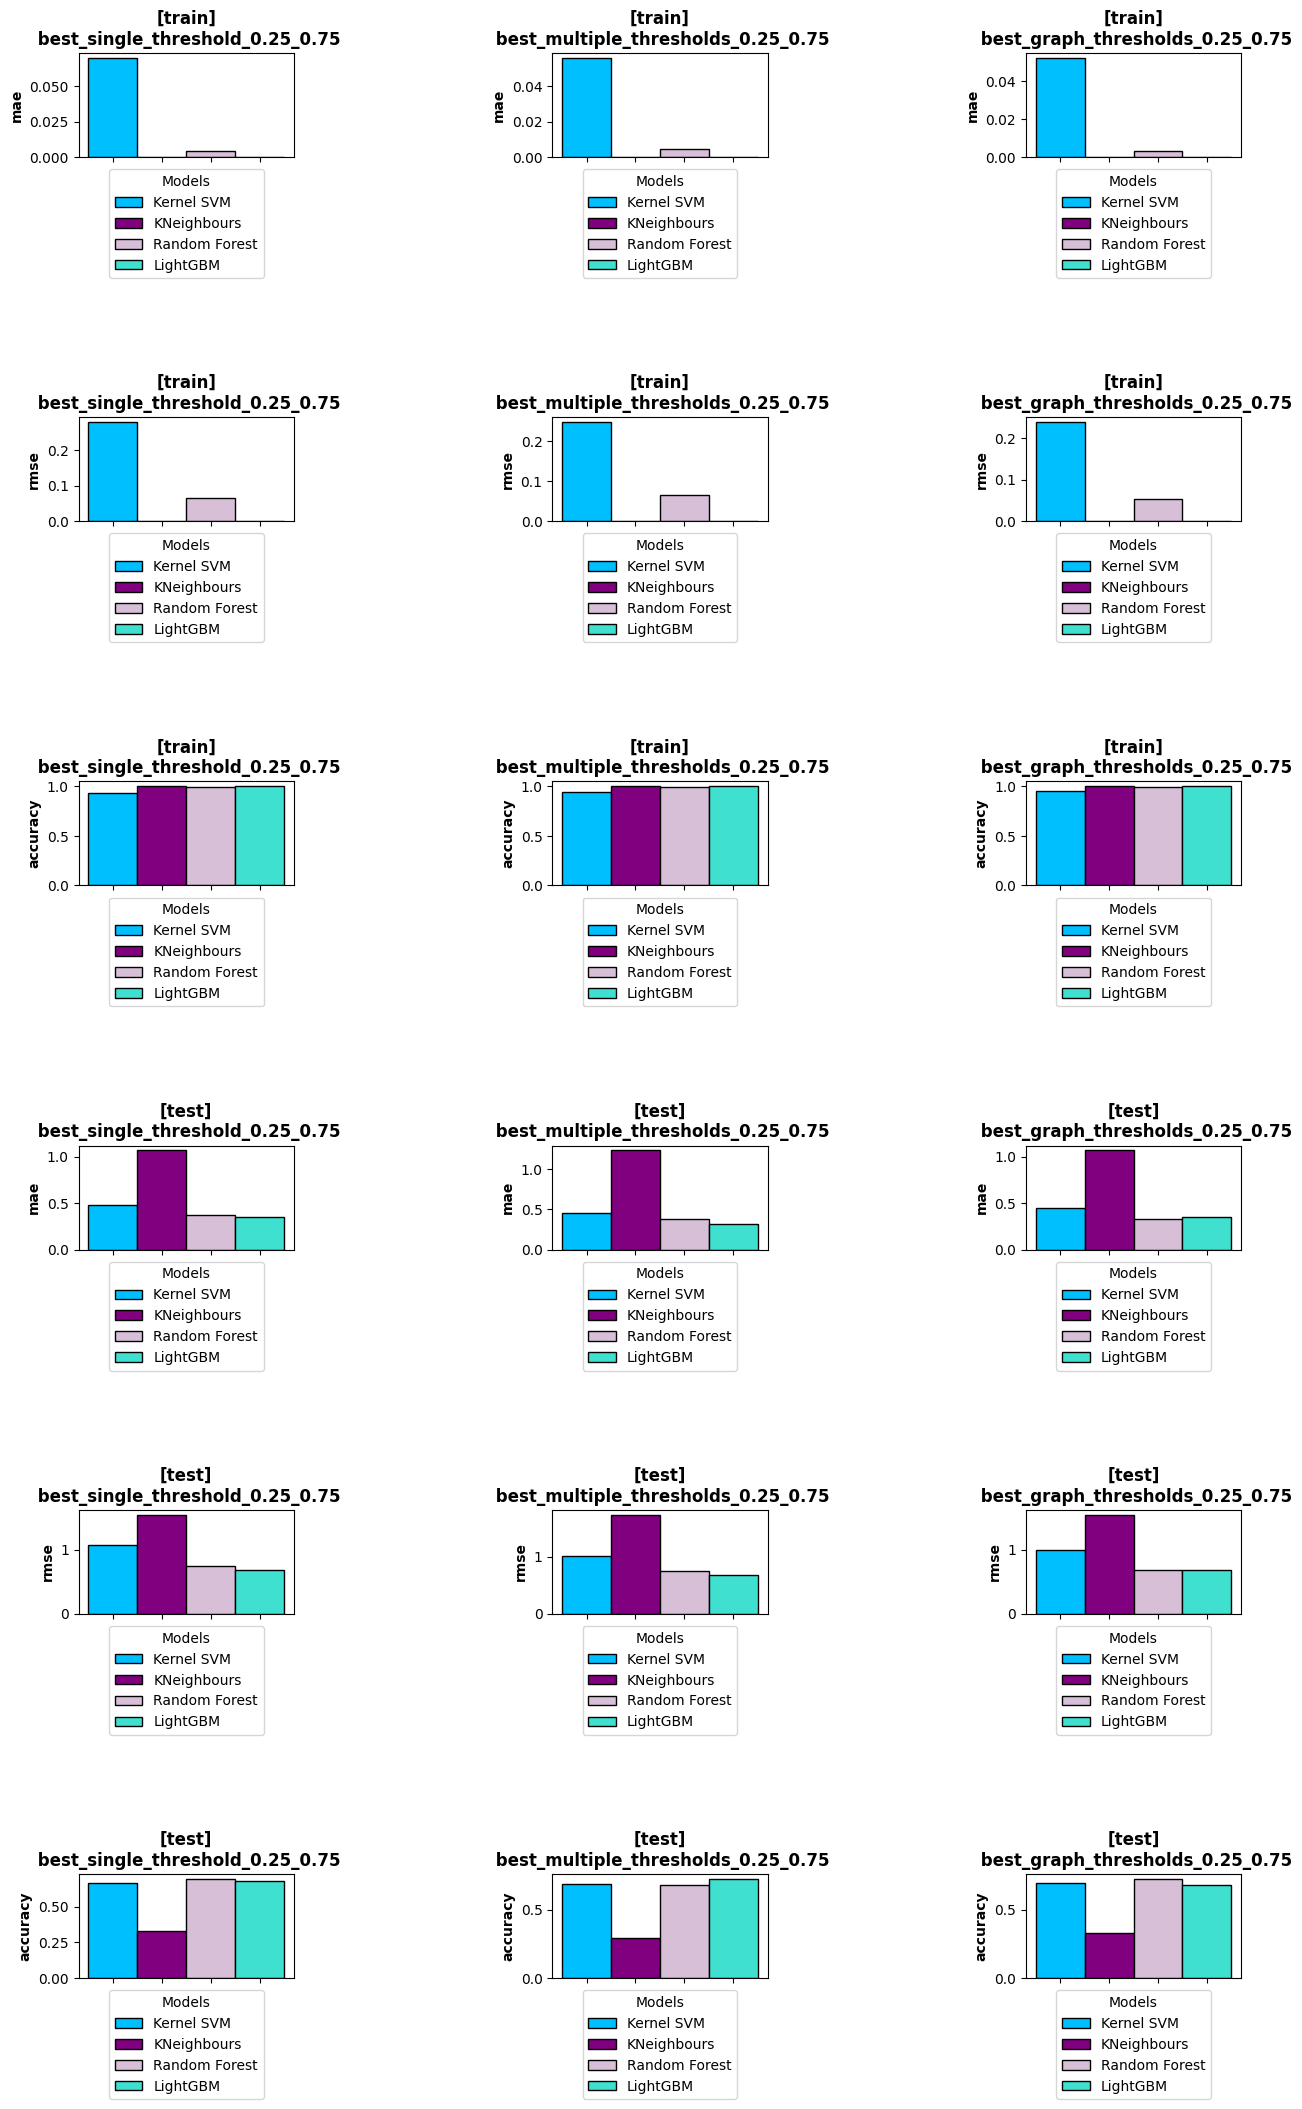

In [9]:
plot_results(
    results,
    measure_types=["mae", "rmse", "accuracy"],
    figsize=(15, 25),
    sets=[
        "train",
        "test",
    ],
    rounding_types=[
        # "no_rounding",
        # "round 0.5",
        # "best_single_threshold_0.05_0.95",
        # "best_multiple_thresholds_0.05_0.95",
        # "best_graph_thresholds_0.05_0.95",
        "best_single_threshold_0.25_0.75",
        "best_multiple_thresholds_0.25_0.75",
        "best_graph_thresholds_0.25_0.75",
    ],
    hspace=2.5,
    wspace=1.2,
)

In [7]:
from training.train_and_evaluate_models import print_results

for model_name, model in results.items():
    print_results(model_name, model)

==== kernel_svm ====
	--> no_rounding
		--> train
			--> rmse: 0.2709546148033673
			--> mae: 0.17606718192161624
		--> test
			--> rmse: 1.0359407498545896
			--> mae: 0.564048215241779
	--> round 0.5
		--> train
			--> rmse: 0.28450284536598086
			--> mae: 0.07211184694628403
			--> accuracy: 0.9315673289183223
		--> test
			--> rmse: 1.0641207361838554
			--> mae: 0.47058823529411764
			--> accuracy: 0.6801470588235294
	--> best_single_threshold_0.05_0.95
		--> threshold
			--> 0.55
		--> train
			--> rmse: 0.2779616756978071
			--> mae: 0.06990434142752024
			--> accuracy: 0.9330389992641648
		--> test
			--> rmse: 1.06929058395797
			--> mae: 0.48161764705882354
			--> accuracy: 0.6691176470588235
	--> best_multiple_thresholds_0.05_0.95
		--> thresholds
			--> -1: 0.8826699985436338
			--> 0: 0.18731646885608635
			--> 1: 0.5004098639302103
			--> 2: 0.30247446445383236
			--> 3: 0.3423033784057899
			--> 4: 0.4866423448282337
			--> 5: 0.7670774767954007
			--> 6: 0.4536711090214

In [79]:
results = train_and_evaluate_models(
    [
        "kernel_svm",
        "knn",
        "random_forest",
        "lightgbm",
    ],
    X_train,
    y_train,
    X_test,
    y_test,
    thresholds=[0.05 for i in range(5, 16)],
)

[I 2024-05-18 19:26:00,875] A new study created in memory with name: no-name-b42631a8-efd4-4f7f-bdf9-8f46ccef473e
[I 2024-05-18 19:26:00,881] Trial 0 finished with value: 0.08830022075055188 and parameters: {'level_-1': 0.29278687364417944, 'level_0': 0.557962378861572, 'level_1': 0.25540157785972284, 'level_2': 0.629204373758165, 'level_3': 0.4492753471190576, 'level_4': 0.538167332219517, 'level_5': 0.5262331571729375, 'level_6': 0.2845328853080833, 'level_7': 0.37489946293187226, 'level_8': 0.5017149196793677, 'level_9': 0.339678121100297, 'level_10': 0.4662986477411426, 'level_11': 0.2814436393155065, 'level_12': 0.36956156185470673, 'level_13': 0.28476009460735857, 'level_14': 0.3210372752659089, 'level_15': 0.4147561479402068, 'level_16': 0.5356805990159714, 'level_17': 0.4678304334827815, 'level_18': 0.7003585376706571, 'level_19': 0.7214701188479125, 'level_20': 0.445524592642395}. Best is trial 0 with value: 0.08830022075055188.
[I 2024-05-18 19:26:00,885] Trial 1 finished wit

{-1: 0.75, 0: 0.30000000000000004, 1: 0.4, 2: 0.30000000000000004, 3: 0.5, 4: 0.5, 5: 0.55, 6: 0.4, 7: 0.45, 8: 0.45, 9: 0.25, 10: 0.35000000000000003, 11: 0.25, 12: 0.25, 13: 0.25, 14: 0.30000000000000004, 15: 0.25, 16: 0.4, 17: 0.25, 18: 0.25, 19: 0.25, 20: 0.25}


[I 2024-05-18 19:26:11,332] Trial 10 finished with value: 0.0 and parameters: {'level_-1': 0.2705074803132791, 'level_0': 0.28139400856306146, 'level_1': 0.25550241688688297, 'level_2': 0.41985109684709665, 'level_3': 0.5743201506615124, 'level_4': 0.7428129451753092, 'level_5': 0.7083914949424608, 'level_6': 0.26651063397918445, 'level_7': 0.25334674212008734, 'level_8': 0.25551268836952257, 'level_9': 0.5624325112643289, 'level_10': 0.6239163857364429, 'level_11': 0.7432994624698408, 'level_12': 0.46176392509154407, 'level_13': 0.4308287039219037, 'level_14': 0.740556003308618, 'level_15': 0.743104326487928, 'level_16': 0.7492539980389269, 'level_17': 0.38839058063045445, 'level_18': 0.5672609765436486, 'level_19': 0.7469337493348003, 'level_20': 0.2546700421101439}. Best is trial 0 with value: 0.0.
[I 2024-05-18 19:26:11,445] Trial 11 finished with value: 0.0 and parameters: {'level_-1': 0.40631512625455635, 'level_0': 0.428223152232614, 'level_1': 0.42409832618116516, 'level_2': 0.

{-1: 0.25, 0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25, 5: 0.25, 6: 0.25, 7: 0.25, 8: 0.25, 9: 0.25, 10: 0.25, 11: 0.25, 12: 0.25, 13: 0.25, 14: 0.25, 15: 0.25, 16: 0.25, 17: 0.25, 18: 0.25, 19: 0.25, 20: 0.25}


[I 2024-05-18 19:26:22,167] A new study created in memory with name: no-name-d14a72ca-5986-439d-a1de-0ad60f0683dd
[I 2024-05-18 19:26:22,176] Trial 0 finished with value: 0.008830022075055188 and parameters: {'level_-1': 0.6105637320886906, 'level_0': 0.6258998722696303, 'level_1': 0.329573399813147, 'level_2': 0.6757560029034471, 'level_3': 0.7034817082810914, 'level_4': 0.335532756297164, 'level_5': 0.6312348300537487, 'level_6': 0.6345585899425032, 'level_7': 0.4020874335935158, 'level_8': 0.25933109987500713, 'level_9': 0.4525418849937588, 'level_10': 0.4565769113415527, 'level_11': 0.3198330528849351, 'level_12': 0.49947223795528667, 'level_13': 0.6173901524102334, 'level_14': 0.378196790048286, 'level_15': 0.46267110407185336, 'level_16': 0.6687462945431772, 'level_17': 0.6295386515944028, 'level_18': 0.7046233933714428, 'level_19': 0.3354310264024289, 'level_20': 0.36240699219181977}. Best is trial 0 with value: 0.008830022075055188.
[I 2024-05-18 19:26:22,181] Trial 1 finished 

{-1: 0.35000000000000003, 0: 0.35000000000000003, 1: 0.30000000000000004, 2: 0.45, 3: 0.25, 4: 0.25, 5: 0.30000000000000004, 6: 0.25, 7: 0.30000000000000004, 8: 0.25, 9: 0.25, 10: 0.30000000000000004, 11: 0.25, 12: 0.45, 13: 0.25, 14: 0.25, 15: 0.25, 16: 0.30000000000000004, 17: 0.30000000000000004, 18: 0.25, 19: 0.25, 20: 0.25}


[I 2024-05-18 19:26:32,705] A new study created in memory with name: no-name-746c0b71-31d6-43db-afe8-dff41b03472f
[I 2024-05-18 19:26:32,714] Trial 0 finished with value: 0.0 and parameters: {'level_-1': 0.5923686060305312, 'level_0': 0.6334554866683407, 'level_1': 0.28793669948908834, 'level_2': 0.49769328174077887, 'level_3': 0.4019781434050757, 'level_4': 0.509260038536949, 'level_5': 0.6439537798881985, 'level_6': 0.3271784386262742, 'level_7': 0.40779987678097074, 'level_8': 0.37598964716574484, 'level_9': 0.2592007965066024, 'level_10': 0.4432528744572547, 'level_11': 0.5246576085357739, 'level_12': 0.6920404349875615, 'level_13': 0.6184951497244122, 'level_14': 0.3486412685903527, 'level_15': 0.28361895278371585, 'level_16': 0.33060981531612293, 'level_17': 0.5804827097814729, 'level_18': 0.4596381812911832, 'level_19': 0.7130384410359283, 'level_20': 0.39698038628552984}. Best is trial 0 with value: 0.0.
[I 2024-05-18 19:26:32,722] Trial 1 finished with value: 0.0 and parameter

{-1: 0.25, 0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25, 5: 0.25, 6: 0.25, 7: 0.25, 8: 0.25, 9: 0.25, 10: 0.25, 11: 0.25, 12: 0.25, 13: 0.25, 14: 0.25, 15: 0.25, 16: 0.25, 17: 0.25, 18: 0.25, 19: 0.25, 20: 0.25}


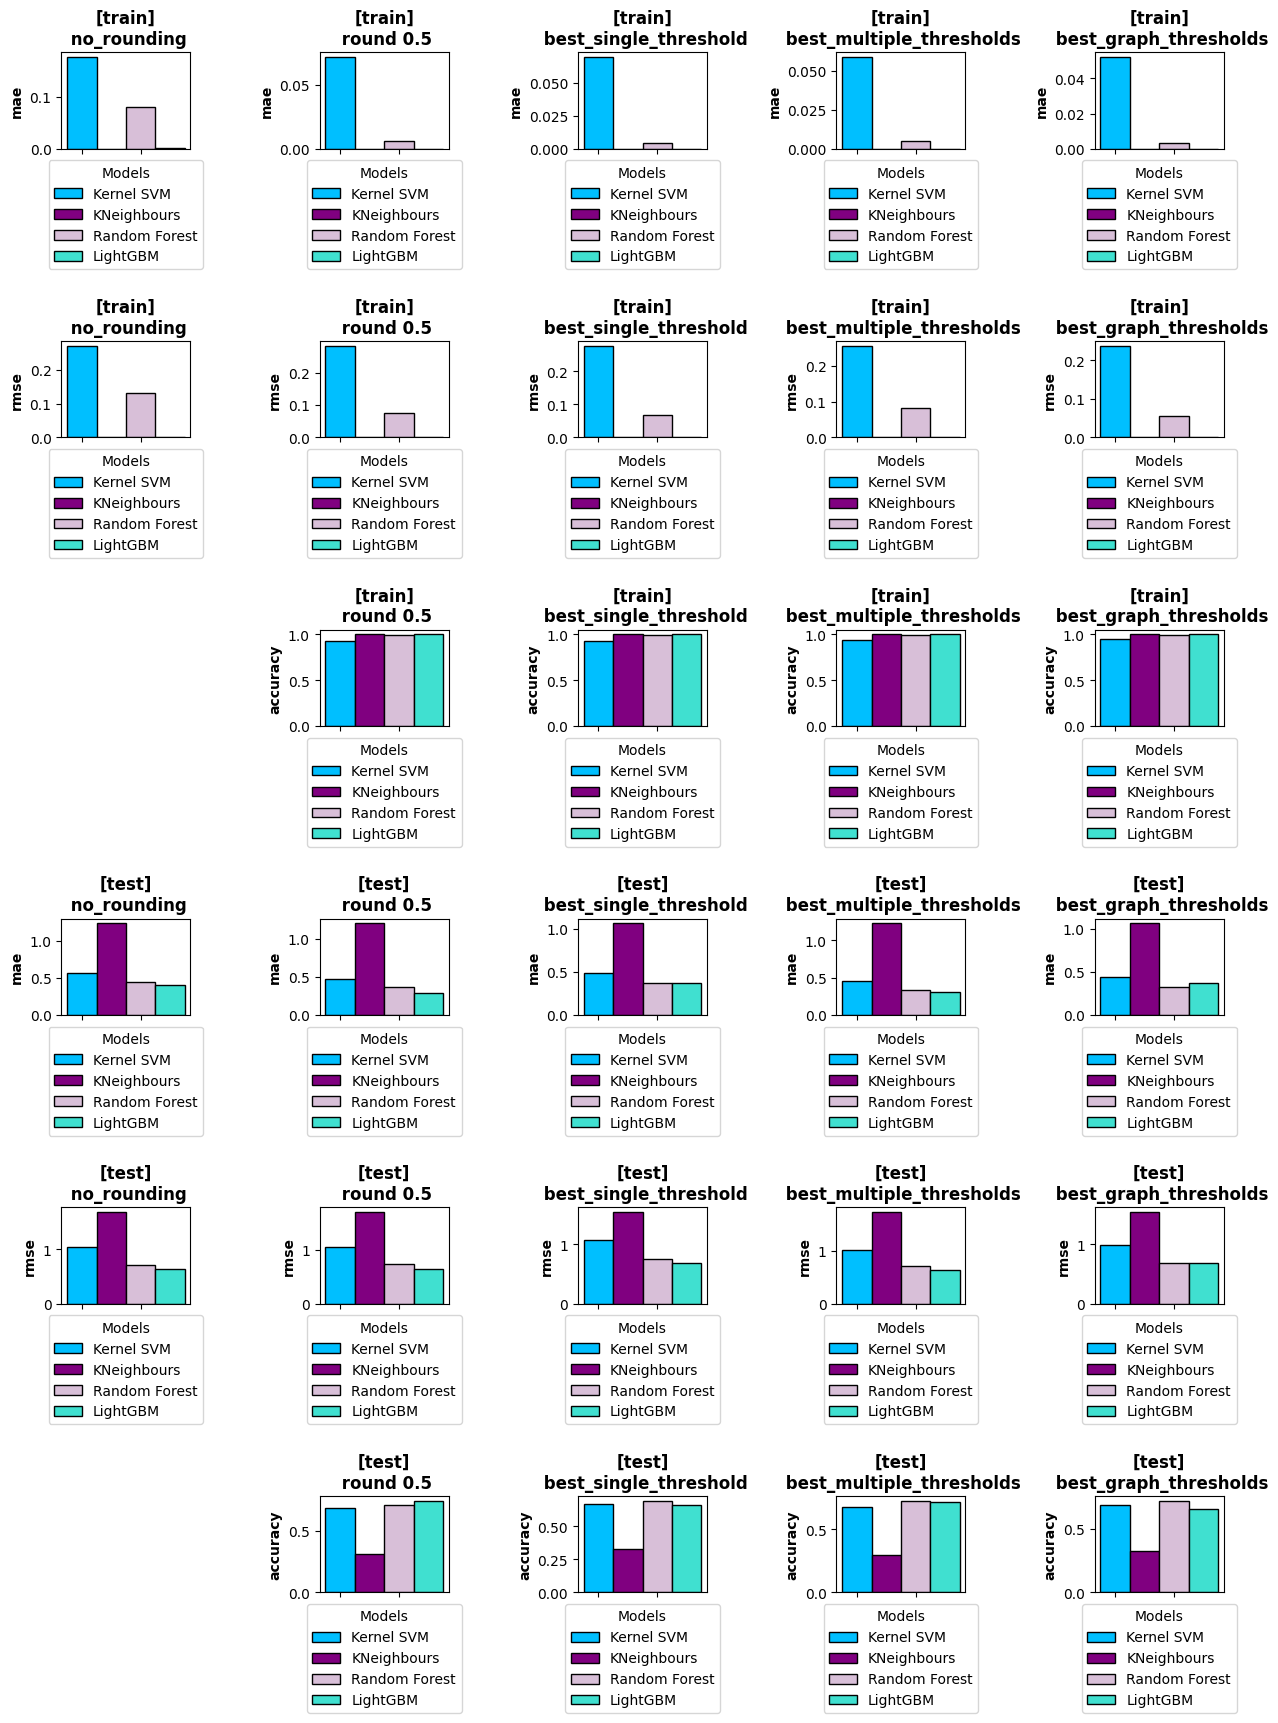

In [80]:
from training.train_and_evaluate_models import train_and_evaluate_models


results = train_and_evaluate_models(
    [
        "linear_regression",
    ],
    X_train,
    y_train,
    X_test,
    y_test,
    thresholds=[0.05 for i in range(1, 20)],
    print_summary=False,
)

In [81]:
results

==== kernel_svm ====
	--> no_rounding
		--> train
			--> rmse: 0.2709546148033673
			--> mae: 0.17606718192161624
		--> test
			--> rmse: 1.0359407498545896
			--> mae: 0.564048215241779
	--> round 0.5
		--> train
			--> rmse: 0.28450284536598086
			--> mae: 0.07211184694628403
			--> accuracy: 0.9315673289183223
		--> test
			--> rmse: 1.0641207361838554
			--> mae: 0.47058823529411764
			--> accuracy: 0.6801470588235294
	--> best_single_threshold
		--> threshold
			--> 0.55
		--> train
			--> rmse: 0.2779616756978071
			--> mae: 0.06990434142752024
			--> accuracy: 0.9330389992641648
		--> test
			--> rmse: 1.06929058395797
			--> mae: 0.48161764705882354
			--> accuracy: 0.6691176470588235
	--> best_multiple_thresholds
		--> thresholds
			--> -1: 0.7250030838899472
			--> 0: 0.5776827422669403
			--> 1: 0.4382435236741495
			--> 2: 0.4920827323525746
			--> 3: 0.4980496782898549
			--> 4: 0.5181033606073091
			--> 5: 0.4917300823002626
			--> 6: 0.46876681058661174
			--> 7: 0.54815

In [84]:
from training.results import plot_results


plot_results(
    results,
    measure_types=["mae", "rmse", "accuracy"],
    figsize=(15, 20),
    sets=[
        "train",
        "test",
    ],
    rounding_types=[
        "no_rounding",
        "round 0.5",
        "best_single_threshold",
        "best_multiple_thresholds",
        "best_graph_thresholds",
    ],
    hspace=2,
    wspace=1,
)

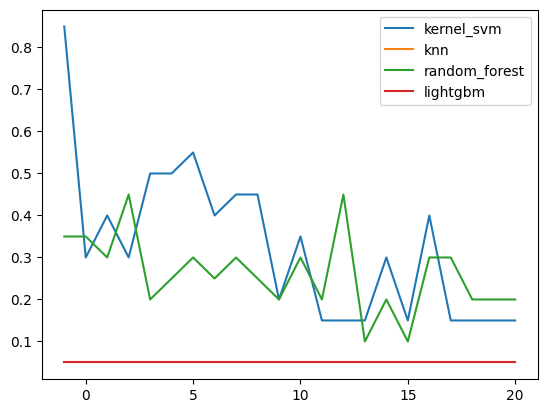

In [85]:
model = results["linear_regression"]["model"]

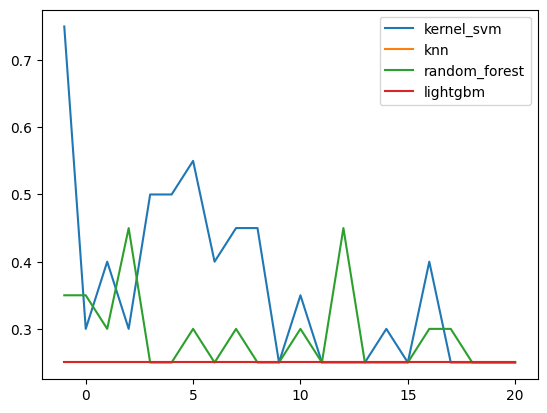

In [86]:
y_pred_train = model.predict(X_train)

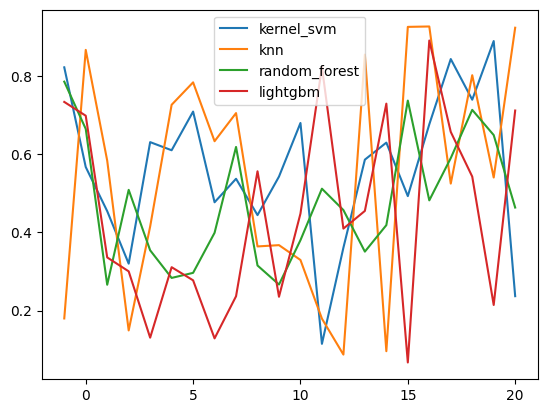

In [87]:
from queue import PriorityQueue
from training.rounging import round_prediction_error


def moves_cost(level, thresholds, y_pred, y_true):
    lvl_pred = [pred for pred in range(len(y_pred)) if y_pred[pred] // 1 == level]
    n = len(lvl_pred)
    moves = []
    for threshold in thresholds:
        moves.append(
            (
                threshold,
                sum(
                    [
                        round_prediction_error(y_pred[i], y_true[i], threshold)
                        for i in lvl_pred
                    ]
                )
                / n,
            )
        )

    return moves


def graph_rounding(y_pred, y_true, thresholds):
    q = PriorityQueue()
    final_thresholds = {}
    q.put((0, -1))

    while not q.empty():
        cost, level = q.get()
        if level == 21:
            return final_thresholds

        moves = moves_cost(level, thresholds, y_pred, y_true)
        threshold, next_cost = min(moves, key=lambda x: x[1])
        final_thresholds[level] = threshold
        q.put((cost + next_cost, level + 1))

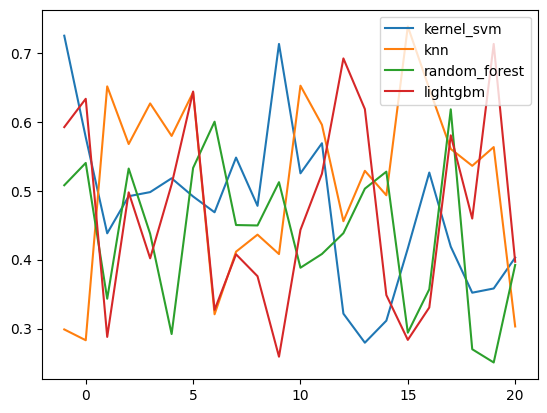

In [88]:
graph_rounding(list(y_pred_train), list(y_train), [0.1 * i for i in range(1, 10)])

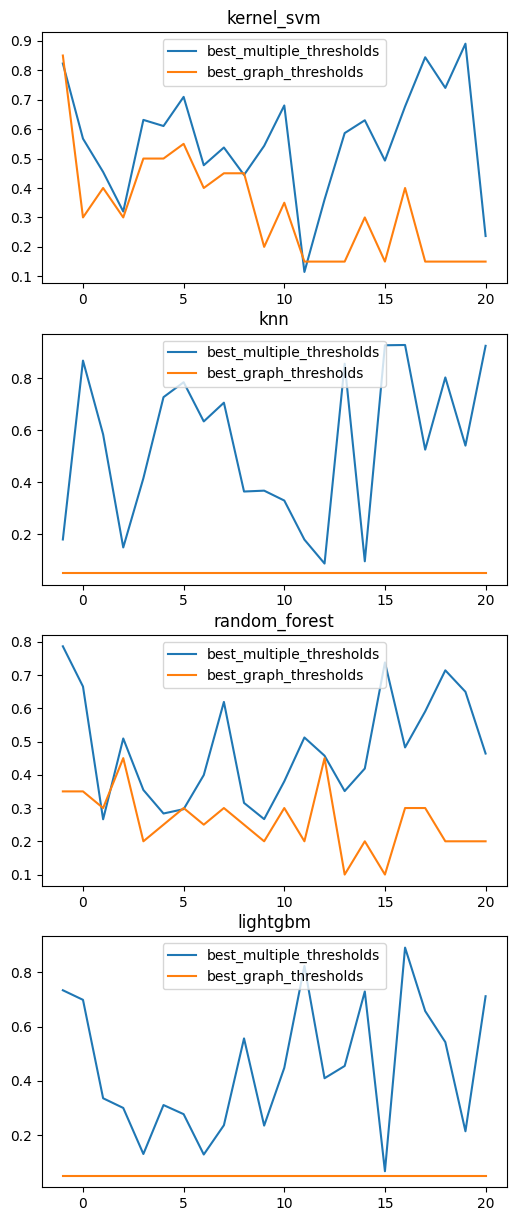